<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

# <CENTER><h1> Two-lepton final state: the case of SM Higgs boson production in the decay channel $H \rightarrow WW^{*}$

This notebook provides the analysis of Higgs decaying into two W bosons with two leptons in the final state. The production of Higgs boson comes from gluon-gluon fusion and vector-boson fusion processes and they form our signal. The main source of background comes from:
* non-resonat WW diboson production process
* $t \bar{t}$ and single top
* non-resonant WZ and ZZ diboson production process
* boson Z or W + jets (with the jet misidentified as a lepton)

At the end of this analysis, you will be able to get plots with the mass of the two lepton system, the transverse momentum of the two lepton system, the missing transverse energy and the reconstructed mass with all of them having into account the contribution of MC samples (a stacked plot). Here you can find many tools to perform the desired selection of events, how to declarate histograms, variables, read ROOT files and so on. 

The Feynman diagram of our process can be shown below:

$H \rightarrow WW \rightarrow e^{-} \bar{\nu_{e}} \mu^{+} \nu_{\mu}$ | $H \rightarrow WW \rightarrow \mu^{-} \bar{\nu_{\mu}} e^{+} \nu_{e}$ |
:-------------------------:|:-------------------------:
![Graviton 4e](../images/HWWenumunu.png)  |  ![Graviton 4 mu](../images/HWWmunuposnu.png) | 

The first step is to load some basic libraries of c++:

In [1]:
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>

The data we want to use to perform our analysis can be found in [folder 2 lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/). Here you will see the data and MC samples that corresponds to 2 leptons in the final state. We also define a variable named lumi, which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analysis over a fraction of the whole data and MC samples, we can define another variable named fraction, which will be defined equal to 0.1 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plot:

In [2]:
float lumi = 10.; //fb^{-1}
float fraction = 0.1;
TString path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/";  

Next, we define some maps which will represent the main groups of background in our analysis for MC samples. These maps will save the name of each ROOT file used for the analysis and their corresponding scale given by a weight factor. This weight factor is given by considering the efficiency of calorimeters, the sum of all weights for each sample and the cross section for each sample. All of this parameter can be found in the sample.txt file in the same folder of this notebook.

In [3]:
std::map<TString, float> db;
std::map<TString, float> stop;
std::map<TString, float> vj;
std::map<TString, float> ttb;
std::map<TString, float> h;

Once we have defined the maps, we can start by defining the signal and backgrounds histograms we are going to fill, taking into account the variables of our interest:
* mLL: mass of the two lepton system
* ptLL: transverse momentum of the two lepton system
* etmiss: missing transverse energy 
* mt: reconstructed mass

In [4]:
//data:
TH1F *data_hist_mLL = new TH1F("data_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *data_hist_ptLL = new TH1F("data_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *data_hist_etmiss = new TH1F("data_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *data_hist_mt = new TH1F("data_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

//ggH125_WW and VBFH125_WW (Higgs):
TH1F *higgs_hist_mLL = new TH1F("higgs_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *higgs_hist_ptLL = new TH1F("higgs_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *higgs_hist_etmiss = new TH1F("higgs_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *higgs_hist_mt = new TH1F("higgs_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

//diboson VBFH125_WW
TH1F *diboson_hist_mLL = new TH1F("diboson_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *diboson_hist_ptLL = new TH1F("diboson_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *diboson_hist_etmiss = new TH1F("diboson_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *diboson_hist_mt = new TH1F("diboson_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

//V+jets
TH1F *vjets_hist_mLL = new TH1F("vjets_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *vjets_hist_ptLL = new TH1F("vjets_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *vjets_hist_etmiss = new TH1F("vjets_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *vjets_hist_mt = new TH1F("vjets_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

//ttbar
TH1F *ttbar_hist_mLL = new TH1F("ttbar_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *ttbar_hist_ptLL = new TH1F("ttbar_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *ttbar_hist_etmiss = new TH1F("ttbar_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *ttbar_hist_mt = new TH1F("ttbar_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

//single top
TH1F *single_top_hist_mLL = new TH1F("single_top_hist_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
TH1F *single_top_hist_ptLL = new TH1F("single_top_hist_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
TH1F *single_top_hist_etmiss = new TH1F("single_top_hist_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
TH1F *single_top_hist_mt = new TH1F("single_top_hist_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);

In order to save the information storaged in the ROOT files, we define all variables we are going to use in the next code line: 

In [5]:
Float_t         mcWeight;
Float_t         scaleFactor_PILEUP;
Float_t         scaleFactor_ELE;
Float_t         scaleFactor_MUON;
Float_t         scaleFactor_LepTRIGGER;
Bool_t          trigE;
Bool_t          trigM;
UInt_t          lep_n;
vector<float>   *lep_pt;
vector<float>   *lep_eta;
vector<float>   *lep_phi;
vector<float>   *lep_E;
vector<float>   *lep_z0;
vector<int>     *lep_charge;
vector<unsigned int> *lep_type;
vector<bool>    *lep_isTightID;
vector<float>   *lep_ptcone30;
vector<float>   *lep_etcone20;
vector<float>   *lep_trackd0pvunbiased;
vector<float>   *lep_tracksigd0pvunbiased;
Float_t         met_et;
Float_t         met_phi;
UInt_t          jet_n;
vector<float>   *jet_pt;
vector<float>   *jet_eta;
vector<float>   *jet_phi;
vector<float>   *jet_E;
vector<float>   *jet_jvt;
vector<float>   *jet_MV2c10;

For all samples we use, we have to rewrite the variables defined previously, so we create a function that receives the name of the chain (We mean, the name of the background or the data depending on which sample we are analysing), the name of the sample and their DSID (a number that identifies each MC sample). This function returns a tree with the information of the sample and rewrites the variables we use at the same time. It also reads the information of samples by editing the tuple path, so it is important to separate data and MC samples because they are storaged in different folders into the [folder 2 lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/). It is only needed to consider an extra variable of type TString named prefix in order to divide them:

In [6]:
TTree* set_branch_address(TString name_chain, TString name_sample, int DSID_id)
{
    ostringstream DSID;
    DSID << DSID_id;
    TString sDSID = DSID.str();
    
    TString prefix, fileString;
    
    if(name_chain=="data"){
        prefix = "Data/";
        
    }
    else{
        prefix = "MC/mc_"+sDSID+".";
    }
    
    fileString = path+prefix+name_sample+".2lep.root";
    
    TFile *file = TFile::Open(fileString);
    TTree *tree = (TTree*) file->Get("mini");
    
    tree->SetBranchAddress("trigE", &trigE); 
    tree->SetBranchAddress("trigM", &trigM); 
    tree->SetBranchAddress("lep_isTightID", &lep_isTightID); 
    tree->SetBranchAddress("lep_pt", &lep_pt); 
    tree->SetBranchAddress("lep_eta", &lep_eta); 
    tree->SetBranchAddress("lep_phi", &lep_phi); 
    tree->SetBranchAddress("lep_E", &lep_E); 
    tree->SetBranchAddress("lep_n", &lep_n); 
    tree->SetBranchAddress("lep_type", &lep_type); 
    tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
    tree->SetBranchAddress("lep_etcone20", &lep_etcone20);
    tree->SetBranchAddress("lep_trackd0pvunbiased", &lep_trackd0pvunbiased); 
    tree->SetBranchAddress("lep_tracksigd0pvunbiased", &lep_tracksigd0pvunbiased); 
    tree->SetBranchAddress("lep_z0", &lep_z0); 
    tree->SetBranchAddress("lep_type", &lep_type); 
    tree->SetBranchAddress("lep_charge", &lep_charge); 
    tree->SetBranchAddress("met_et", &met_et); 
    tree->SetBranchAddress("jet_n", &jet_n);
    tree->SetBranchAddress("jet_pt", &jet_pt); 
    tree->SetBranchAddress("jet_eta", &jet_eta);
    tree->SetBranchAddress("jet_jvt", &jet_jvt); 
    tree->SetBranchAddress("jet_MV2c10", &jet_MV2c10); 
    
    tree->SetBranchAddress("mcWeight", &mcWeight); 
    tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP); 
    tree->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE); 
    tree->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON); 
    tree->SetBranchAddress("scaleFactor_LepTRIGGER", &scaleFactor_LepTRIGGER); 
    
    return tree; 
}

The scaling histogram function will allow us to scale the histograms to compare data and the contribution of MC samples. This function uses the weight of scaling due to efficiency of the calorimeters, the sum of weights for MC and the cross section samples to scale the contributions of all samples. Of course, the data samples are not needed to be scaled, this only apply for MC samples:

In [7]:
void scaling_histogram(TString name_chain, TString name_sample, int n_sample, TString name_hist, TH1F *hist_sample)
{
    if(name_chain=="data"){
        if(n_sample==0){ 
            if(name_hist=="mLL"){ data_hist_mLL = (TH1F*) hist_sample->Clone();} 
            if(name_hist=="ptLL"){ data_hist_ptLL = (TH1F*) hist_sample->Clone();}
            if(name_hist=="etmiss"){ data_hist_etmiss = (TH1F*) hist_sample->Clone();}
            if(name_hist=="mt"){ data_hist_mt = (TH1F*) hist_sample->Clone();}            
        }
        if(n_sample!=0){ 
            if(name_hist=="mLL"){ data_hist_mLL->Add(hist_sample);}
            if(name_hist=="ptLL"){ data_hist_ptLL->Add(hist_sample);}
            if(name_hist=="etmiss"){ data_hist_etmiss->Add(hist_sample);}
            if(name_hist=="mt"){ data_hist_mt->Add(hist_sample);}        
        }
    }
    
    if(name_chain == "diboson"){
        for(std::map<TString, float>::iterator it = db.begin(); it != db.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second);
                if(n_sample==0){ 
                    if(name_hist=="mLL"){ diboson_hist_mLL = (TH1F*) hist_sample->Clone();} 
                    if(name_hist=="ptLL"){ diboson_hist_ptLL = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="etmiss"){ diboson_hist_etmiss = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="mt"){ diboson_hist_mt = (TH1F*) hist_sample->Clone();}
                }
                if(n_sample!=0){ 
                    if(name_hist=="mLL"){ diboson_hist_mLL->Add(hist_sample);}
                    if(name_hist=="ptLL"){ diboson_hist_ptLL->Add(hist_sample);}
                    if(name_hist=="etmiss"){ diboson_hist_etmiss->Add(hist_sample);}
                    if(name_hist=="mt"){ diboson_hist_mt->Add(hist_sample);}
                }
            }
        }
    } 
    if(name_chain == "single_top"){
        for(std::map<TString, float>::iterator it = stop.begin(); it != stop.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second);
                if(n_sample==0){ 
                    if(name_hist=="mLL"){ single_top_hist_mLL = (TH1F*) hist_sample->Clone();} 
                    if(name_hist=="ptLL"){ single_top_hist_ptLL = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="etmiss"){ single_top_hist_etmiss = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="mt"){ single_top_hist_mt = (TH1F*) hist_sample->Clone();}
                }
                if(n_sample!=0){ 
                    if(name_hist=="mLL"){ single_top_hist_mLL->Add(hist_sample);}
                    if(name_hist=="ptLL"){ single_top_hist_ptLL->Add(hist_sample);}
                    if(name_hist=="etmiss"){ single_top_hist_etmiss->Add(hist_sample);}
                    if(name_hist=="mt"){ single_top_hist_mt->Add(hist_sample);}
                }
            }
        }
    } 
    if(name_chain == "vjets"){
        for(std::map<TString, float>::iterator it = vj.begin(); it != vj.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second);
                if(n_sample==0){ 
                    if(name_hist=="mLL"){ vjets_hist_mLL = (TH1F*) hist_sample->Clone();} 
                    if(name_hist=="ptLL"){ vjets_hist_ptLL = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="etmiss"){ vjets_hist_etmiss = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="mt"){ vjets_hist_mt = (TH1F*) hist_sample->Clone();}
                }
                if(n_sample!=0){ 
                    if(name_hist=="mLL"){ vjets_hist_mLL->Add(hist_sample);}
                    if(name_hist=="ptLL"){ vjets_hist_ptLL->Add(hist_sample);}
                    if(name_hist=="etmiss"){ vjets_hist_etmiss->Add(hist_sample);}
                    if(name_hist=="mt"){ vjets_hist_mt->Add(hist_sample);}
                }
            }
        }
    }       
    if(name_chain == "ttbar"){
        for(std::map<TString, float>::iterator it = ttb.begin(); it != ttb.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second);
                if(n_sample==0){ 
                    if(name_hist=="mLL"){ ttbar_hist_mLL = (TH1F*) hist_sample->Clone();} 
                    if(name_hist=="ptLL"){ ttbar_hist_ptLL = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="etmiss"){ ttbar_hist_etmiss = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="mt"){ ttbar_hist_mt = (TH1F*) hist_sample->Clone();}
                }
                if(n_sample!=0){ 
                    if(name_hist=="mLL"){ ttbar_hist_mLL->Add(hist_sample);}
                    if(name_hist=="ptLL"){ ttbar_hist_ptLL->Add(hist_sample);}
                    if(name_hist=="etmiss"){ ttbar_hist_etmiss->Add(hist_sample);}
                    if(name_hist=="mt"){ ttbar_hist_mt->Add(hist_sample);}
                }
            }
        }
    }
    if(name_chain == "higgs"){
        for(std::map<TString, float>::iterator it = h.begin(); it != h.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second);
                if(n_sample==0){ 
                    if(name_hist=="mLL"){ higgs_hist_mLL = (TH1F*) hist_sample->Clone();} 
                    if(name_hist=="ptLL"){ higgs_hist_ptLL = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="etmiss"){ higgs_hist_etmiss = (TH1F*) hist_sample->Clone();}
                    if(name_hist=="mt"){ higgs_hist_mt = (TH1F*) hist_sample->Clone();}
                }
                if(n_sample!=0){ 
                    if(name_hist=="mLL"){ higgs_hist_mLL->Add(hist_sample);}
                    if(name_hist=="ptLL"){ higgs_hist_ptLL->Add(hist_sample);}
                    if(name_hist=="etmiss"){ higgs_hist_etmiss->Add(hist_sample);}
                    if(name_hist=="mt"){ higgs_hist_mt->Add(hist_sample);}
                }
            }
        }
    }
}

Now, we define a function that computes the factor weight due to the information in the samples.txt file. Altough this proccess was done manually, you could edit it in order to read information for the sample.txt automatically by using the library fstream. We didn't use it in order to save time for the analysis. If you need to add samples, you will have to look for their information in the samples.txt file. 

In [8]:
void get_xsec_weight()
{
    // sample - xsec - red_eff - sumw - nevt; look for the sample.txt if you add a sample to the analysis
    float xsec=0, red_eff=0, sumw=0; 
        
    //diboson
    
    //ZqqZll		2.20355112		1		3439266.11559		5317000
    xsec=2.20355112, red_eff=1.0, sumw=3439266.11559;
    db["ZqqZll"] = lumi*1000*xsec/(red_eff*sumw); 
    
    //WqqZll		3.4328		1		241438.72705		5124000
    xsec=3.4328, red_eff=1.0, sumw=241438.72705;
    db["WqqZll"] = lumi*1000*xsec/(red_eff*sumw); 
         
    //WpqqWmlv		24.708		1		998250.783475		6673000
    xsec=24.708, red_eff=1.0, sumw=998250.783475;
    db["WpqqWmlv"] = lumi*1000*xsec/(red_eff*sumw);
    
    //WplvWmqq		24.724		1		1069526.41899		7115000
    xsec=24.724, red_eff=1.0, sumw=1069526.41899;
    db["WplvWmqq"] = lumi*1000*xsec/(red_eff*sumw);
    
    //WlvZqq		11.42		1		1111991.15979		7100000
    xsec=11.42, red_eff=1.0, sumw=1111991.15979;
    db["WlvZqq"] = lumi*1000*xsec/(red_eff*sumw);
    
    //llll		1.2578		1		7538705.8077		17825300
    xsec=1.2578, red_eff=1.0, sumw=7538705.8077;
    db["llll"] = lumi*1000*xsec/(red_eff*sumw);    
    
    //lllv		4.6049		1		5441475.00407		15772084
    xsec=4.6049, red_eff=1.0, sumw=5441475.00407;
    db["lllv"] = lumi*1000*xsec/(red_eff*sumw);

    //llvv		12.466		1		5039259.9696		14803000
    xsec=12.466, red_eff=1.0, sumw=5039259.9696;
    db["llvv"] = lumi*1000*xsec/(red_eff*sumw);
    
    //lvvv		3.2286		1		1727991.07441		5922600
    xsec=3.2286, red_eff=1.0, sumw=1727991.07441;
    db["lvvv"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Single top
    
    //single_top_tchan		44.152		1		0.218165148808		4986200
    xsec=44.152, red_eff=1.0, sumw=0.218165148808;
    stop["single_top_tchan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //single_antitop_tchan		26.276		1		0.128694693283		4989800
    xsec=26.276, red_eff=1.0, sumw=0.128694693283;
    stop["single_antitop_tchan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //single_top_schan		2.06121		1		0.00204856751068		997800
    xsec=2.06121, red_eff=1.0, sumw=0.00204856751068;
    stop["single_top_schan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //single_antitop_schan		1.288662		1		0.00125651986173		995400
    xsec=1.288662, red_eff=1.0, sumw=0.00125651986173;
    stop["single_antitop_schan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //single_top_wtchan		35.845486		1		4865800		4985800
    xsec=35.845486, red_eff=1.0, sumw=4865800;
    stop["single_top_wtchan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //single_antitop_wtchan		35.824406		1		4945600		4985600
    xsec=35.824406, red_eff=1.0, sumw=4945600;
    stop["single_antitop_wtchan"] = lumi*1000*xsec/(red_eff*sumw);
    
    //v jets

    //Zee		1950.5295		1		150277594200		79045597
    xsec=1950.5295, red_eff=1.0, sumw=150277594200;
    vj["Zee"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Zmumu		1950.6321		1		147334691090		77497800
    xsec=1950.6321, red_eff=1.0, sumw=147334691090;
    vj["Zmumu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Ztautau		1950.6321		1		56171652547.3		29546000
    xsec=1950.6321, red_eff=1.0, sumw=56171652547.3;
    vj["Ztautau"] = lumi*1000*xsec/(red_eff*sumw);
     
    //Wplusenu		11500.4632		1		473389396815		41870000
    xsec=11500.4632, red_eff=1.0, sumw=473389396815;
    vj["Wplusenu"] = lumi*1000*xsec/(red_eff*sumw);    
    
    //Wplusmunu		11500.4632		1		446507925520		39493600
    xsec=11500.4632, red_eff=1.0, sumw=446507925520;
    vj["Wplusmunu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Wplustaunu		11500.4632		1		670928468875		59343600
    xsec=11500.4632, red_eff=1.0, sumw=670928468875;
    vj["Wplustaunu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Wminusenu		8579.63498		1		247538642447		29886000
    xsec=8579.63498, red_eff=1.0, sumw=247538642447;
    vj["Wminusenu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Wminusmunu		8579.63498		1		264338188182		31915400
    xsec=8579.63498, red_eff=1.0, sumw=264338188182;
    vj["Wminusmunu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Wminustaunu		8579.63498		1		165195850954		19945400
    xsec=8579.63498, red_eff=1.0, sumw=165195850954;
    vj["Wminustaunu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //ttbar_lep
    
    //ttbar_lep		452.693559		1		49386600		49386600
    xsec=452.693559, red_eff=1.0, sumw=49386600;
    ttb["ttbar_lep"] = lumi*1000*xsec/(red_eff*sumw);   
    
    //ggH125_WW

    //ggH125_WW2lep		0.1481173588		1		55832659.6908		1972000
    xsec=0.1481173588, red_eff=1.0, sumw=55832659.6908;
    h["ggH125_WW2lep"] = lumi*1000*xsec/(red_eff*sumw);
    
    //VBFH125_WW
    
    //VBFH125_WW2lep		0.02020229148		1		4389990.08913		1175000
    xsec=0.02020229148, red_eff=1.0, sumw=4389990.08913;
    h["VBFH125_WW2lep"] = lumi*1000*xsec/(red_eff*sumw);

}

## Changing a cut

Finally, we are going to apply the corresponding cuts of our analysis. For this reason, we create an individual function for each cut. This would allow us to see the effect of applying each cut over the samples files by separated if we wanted. Of course, we could create only one function that contains all cuts but it wouldn't allow us to see the effects of applying every cut by separated, it would shown us the final events after all cuts so the idea is to keep them separated.

### Lepton trigger cut

This cut needs the trigE and trigM variables. We want to choose events that have either trigE or trigM bool variables equal to True. This requirement tells us that at least, either an electron or muon has been identified in the event.

In [9]:
bool lepton_trigger_cut(bool trigE, bool trigM)
{
    if(trigE || trigM){ return true;}
    return false;
}

### Good leptons number cut

This cut needs the lepton number, if the lepton is Tight ID, the pT, $\eta$, $\phi$, type, ptcone30, etcone30, trackd0pvunbiased, tracksigd0pvunbiased and z0 variables of each lepton in the event. We want to choose events that have only two good leptons according to:

* Lepton is tight ID
* Lepton pT>15GeV
* Isolated lepton (lep_ptcone30/lep_pt and lep_etcone20/lep_pt less than 0.1)
* If the lepton is an electron, $|\eta|<2.4$ and $1.37<|\eta|>1.52$
* If the lepton is a muon, $|\eta|<2.5$

If the event doesn't fulfill this requirement, the event is dropped. At the end, we assign the index of the good leptons to two variables that are passed by reference, which are lep_index1 and lep_index_2 and they will be used after.

In [10]:
bool good_leptons_n_cut(unsigned int lep_n, vector<bool> lep_isTightID, vector<float> lep_pt, vector<float> lep_eta,
                        vector<float> lep_phi, vector<float> lep_E, vector<unsigned int> lep_type, 
                        vector<float> lep_ptcone30, vector<float> lep_etcone20, vector<float> lep_trackd0pvunbiased, 
                        vector<float> lep_tracksigd0pvunbiased, vector<float> lep_z0, 
                        unsigned int &lep_index1, unsigned int &lep_index2)
{
    // Preselection of good leptons
    int goodlep_index[lep_n];
    int goodlep_n = 0;
    int lep_index =0;
      
    for(unsigned int ii=0; ii<lep_n; ii++){
        
        TLorentzVector leptemp = TLorentzVector();  
        leptemp.SetPtEtaPhiE(lep_pt[ii]/1000., lep_eta[ii], lep_phi[ii], lep_E[ii]/1000.);
        
        // Lepton is Tight
        if( lep_isTightID[ii] == false ) continue;
        // standard lepton isolation requirement => strict isolation
        if( lep_pt[ii] <= 15000. ) continue;
        if( lep_ptcone30[ii]/lep_pt[ii] >= 0.1 ) continue; 
        if( lep_etcone20[ii]/lep_pt[ii] >= 0.1 ) continue;
        // electron selection
        if( lep_type[ii]==11 && TMath::Abs(lep_eta[ii])<2.47 && (TMath::Abs(lep_eta[ii])<1.37 || 
                                                                 TMath::Abs(lep_eta[ii])>1.52) ){
            
            if( TMath::Abs(lep_trackd0pvunbiased[ii])/lep_tracksigd0pvunbiased[ii]>=5 ||
                TMath::Abs(lep_z0[ii]*TMath::Sin(leptemp.Theta()))>=0.5) continue;    
            
            goodlep_n++;
            goodlep_index[lep_index] = ii;
            lep_index++;
        }
            
        // muon selection
        if( lep_type[ii]==13 && TMath::Abs(lep_eta[ii])<2.5 ){
            
            if( TMath::Abs(lep_trackd0pvunbiased[ii])/lep_tracksigd0pvunbiased[ii]>=3 || 
               TMath::Abs(lep_z0[ii]*TMath::Sin(leptemp.Theta()))>=0.5) continue;
            
            goodlep_n++;
            goodlep_index[lep_index] = ii;
            lep_index++;
        }
    }
  
    if(goodlep_n!=2){ return false;}
    //Exactly two good leptons, leading lepton with pT > 22 GeV and the subleading lepton with pT > 15 GeV
    lep_index1 = goodlep_index[0];
    lep_index2 = goodlep_index[1];
    if(lep_pt[lep_index1]<=22000. || lep_pt[lep_index2]<=15000.){ return false;}
    return true;
}

### Flavour leptons cut

Because we want one W boson to decay into an electron and neutrino, and the second one to decay into a muon and neutrino, we require that both leptons have different flavour in the final state for all events. If the event doesn't fulfill this requirement, the event is dropped.

In [11]:
//two different-flavour leptons
bool flavour_leptons_cut(vector<unsigned int> lep_type, unsigned int lep_index1, unsigned int lep_index2)
{
    if( lep_type[lep_index1] == lep_type[lep_index2]){return false;} //leptons of same flavours return false
    return true;
}

### Opposite charge leptons cut

This cut select events in which the two good leptons have opposite charges. The reason behind this requirement is that the two W bosons has opposite charges and leptons from the decays of these W bosons have to have different charges in order to keep the neutrality of charge. 

In [12]:
//opposite charge leptons
bool opposite_charges_cut(vector<int> lep_charge, unsigned int lep_index1, unsigned int lep_index2)
{
    if( lep_charge[lep_index1]*lep_charge[lep_index2] > 0){ return false;} //Leptons of same charges return false
    return true;
}

### Number of good jets and bjets cut

Basically, we wouldn't have jets in our final state because de two W bosons would decay into pair of leptons and neutrinos. However, this cut requires that events have at most one jet with $pT > 30 GeV$ and none bjets with $pT > 20 GeV$. In any case the accepted jets has to be in the range for $|\eta|<2.5$ and pass the JVT cleaning. This is done because we don't want to exclude many events from our analysis and we want to consider them to keep a higher statistic. 

In [13]:
bool selection_goodjets_and_zero_bjets_cut(unsigned int jet_n, vector<float> jet_pt, vector<float> jet_eta,
                        vector<float> jet_jvt, vector<float> jet_MV2c10)
{
    //Preselection of good jets
    int goodjet_n = 0;
    int goodbjet_n = 0;
    int goodjet_index[jet_n];
    int jet_index = 0;
    int goodbjet_index[jet_n];
    int bjet_index = 0;
  
    for(unsigned int ii=0; ii<jet_n; ii++){
        if( jet_pt[ii] <= 20000. || TMath::Abs(jet_eta[ii]) >= 2.5 ) continue;

        // JVT cleaning
        if ( jet_pt[ii] < 60000. ){
            if( TMath::Abs(jet_eta[ii]) < 2.4 && jet_jvt[ii] <= 0.59 ) continue;
        }
        
        // cut on 85% WP
        if( jet_MV2c10[ii] > 0.1758475 ){
            if(TMath::Abs(jet_eta[ii]) >= 2.5) continue;
            goodbjet_n++;
            goodbjet_index[bjet_index] = ii;
            bjet_index++;
        }
    
        if( jet_pt[ii] > 30000. ){
            goodjet_n++;
            goodjet_index[jet_index] = ii;
            jet_index++;
        }
    }
    
    if( goodjet_n>1 || goodbjet_n!=0 ){ return false;}
    
    return true;
}

### Low mass meson resonances and DY events; ggF regions cut

Finally, our last cut is applied to:

* The mass of the two lepton system: $10 GeV < m_{ll} < 55 GeV $
* Transverse momentum of the dilepton system: $p_{T}^{ll} > 30 GeV$
* Azimuthal angle between the two leptons: $\Delta \phi (l, l) < 1.8$
* Azimuthal angle between $E_{T}^{miss}$ and the dilepton system: $\Delta \phi (ll, E_{T}^{miss}) > \pi / 2$


In [14]:
// remove low mass meson resonances and DY events; ggF regions
bool low_mass_meson_resonances_DY_and_ggF_regions_cut(float met_et, float mLL, float dPhiLLmet, float ptLL, 
                                                      float dPhi_LL)
{
    if( mLL<=10 || met_et<=20000.){ return false;}
    if( dPhiLLmet<=TMath::Pi()/2 ){ return false;}
    if( ptLL<=30 ){ return false;}
    if( mLL>=55 ){return false;}
    if( dPhi_LL>=1.8 ){return false;} 

    return true;
}

## Applying a cut

The following function computes the main variables that we are going to plot. This function requires the pT, $|\eta|$, $|\phi|$ and energy of both good leptons, and the missing transverse energy and also receives some variables by reference in roder to modify them (such as the $m_{ll}$, $p_{T}^{ll}$, $\Delta \phi (l, l)$, $\Delta \phi (ll, E_{T}^{miss})$ and the $m_{T}$).

In [15]:
void calculation_lepton_variables(vector<float> lep_pt, vector<float> lep_eta, vector<float> lep_phi, vector<float> lep_E,
                                  float met_et, float &mLL, float &ptLL, float &dPhi_LL, float &dPhiLLmet, float &mt, 
                                  unsigned int lep_index1, unsigned int lep_index2)
{
    // TLorentzVector definitions
    TLorentzVector Lepton_1  = TLorentzVector();
    TLorentzVector Lepton_2  = TLorentzVector();
    TLorentzVector      MeT  = TLorentzVector();

    Lepton_1.SetPtEtaPhiE(lep_pt[lep_index1], lep_eta[lep_index1], lep_phi[lep_index1],lep_E[lep_index1]);
    Lepton_2.SetPtEtaPhiE(lep_pt[lep_index2], lep_eta[lep_index2], lep_phi[lep_index2],lep_E[lep_index2]);
    MeT.SetPtEtaPhiE(met_et, 0, met_phi , met_et);
 
    TLorentzVector Lepton_12 = TLorentzVector();
    Lepton_12 = Lepton_1 + Lepton_2;
  
    mLL = Lepton_12.Mag()/1000.;
    ptLL = Lepton_12.Pt()/1000.;
  
    dPhi_LL = TMath::Abs(lep_phi[lep_index1] - lep_phi[lep_index2]);
    dPhi_LL = dPhi_LL < TMath::Pi() ? dPhi_LL : 2*TMath::Pi() - dPhi_LL;
  
    dPhiLLmet = TMath::Abs( Lepton_12.Phi() - MeT.Phi() );
    dPhiLLmet = dPhiLLmet < TMath::Pi() ? dPhiLLmet : 2*TMath::Pi() - dPhiLLmet;
 
    mt = TMath::Sqrt(2*Lepton_12.Pt()*MeT.Et()*(1-cos(Lepton_12.DeltaPhi(MeT))))/1000.;
}

Now, we are going to create a function that performs the event selection for each sample. This function is named "analysis of samples" and requires a name chain (if the sample belongs to data or a main group of background in MC samples), the name sample, its DSID and a number of sample among all samples in its chain of files. This function creates a local histogram, fill it with the computed mass and scaling it with the factor weight saved in the maps, and finally adding it to globals histograms that will be stacked in the final plot.

In [16]:
void analysis_of_samples(TString name_chain, TString name_sample, int DSID_id, int n_sample)
{
    auto start = chrono::steady_clock::now(); //Start the clock
    int nbytes = 0;
    int pass = 0;
    TH1F *hist_sample_mLL = new TH1F("hist_sample_mLL", "Mass of Dilepton System; m_{ll} [GeV];Events / bin", 25, 0, 100);
    TH1F *hist_sample_ptLL = new TH1F("hist_sample_ptLL", "Transverse Momentum of Dilepton System; p_{T}^{ll} [GeV];Events / bin", 30, 0, 200);
    TH1F *hist_sample_etmiss = new TH1F("hist_sample_etmiss", "Missing Transverse Momentum;E_{T}^{miss} [GeV];Events / bin", 20, 0,200);
    TH1F *hist_sample_mt = new TH1F("hist_sample_mt", "Dilepton System Transverse Mass; m_{T} [GeV];Events / bin", 15, 50, 200);
    
    TTree *tree = new TTree(); 
    tree = set_branch_address(name_chain, name_sample, DSID_id);
    int nentries = 0;
    float weight = 0;

    if(name_chain == "data"){ weight = 1.0; }
 
    nentries = (Int_t)tree->GetEntries();
    cout << "\t" << "Processing: "+name_sample << endl;

    for(int ii=0; ii<nentries*fraction; ii++)
    {
        nbytes = tree->GetEntry(ii);
        
        if(name_chain!="data"){
            //Scale factors
            float scaleFactor = scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER*scaleFactor_PILEUP;

            //MC weight
            float m_mcWeight = mcWeight;

            // read input option
            if(name_sample == "single"){ m_mcWeight = (mcWeight/TMath::Abs(mcWeight)); } // set to 1 or -1 for single top MCs

            //Total weight
            weight = scaleFactor*m_mcWeight;
        }
        
        if(lepton_trigger_cut(trigE, trigM) == false) continue;
    
        unsigned int lep_index1 = 0;
        unsigned int lep_index2 = 0;
    
        if(good_leptons_n_cut(lep_n, *lep_isTightID, *lep_pt, *lep_eta, *lep_phi, *lep_E, *lep_type, *lep_ptcone30,
                              *lep_etcone20, *lep_trackd0pvunbiased, *lep_tracksigd0pvunbiased, 
                              *lep_z0, lep_index1, lep_index2) == false) continue;
    
        if(flavour_leptons_cut(*lep_type, lep_index1, lep_index2)==false) continue;
    
        if(opposite_charges_cut(*lep_charge, lep_index1, lep_index2)==false) continue;

        float mLL = 0, ptLL = 0, dPhi_LL = 0, dPhiLLmet = 0, mt = 0; // mases are in GeV, the same for ptLL
        calculation_lepton_variables(*lep_pt, *lep_eta, *lep_phi, *lep_E, met_et, mLL, ptLL, dPhi_LL, dPhiLLmet, mt, 
                                     lep_index1, lep_index2);    
    
        if(selection_goodjets_and_zero_bjets_cut(jet_n, *jet_pt, *jet_eta, *jet_jvt, *jet_MV2c10)==false) continue;
    
        if(low_mass_meson_resonances_DY_and_ggF_regions_cut(met_et, mLL, dPhiLLmet, ptLL, dPhi_LL)==false) continue;
     
        hist_sample_mLL->Fill(mLL, weight);
        hist_sample_ptLL->Fill(ptLL, weight);
        hist_sample_etmiss->Fill(met_et/1000., weight);
        hist_sample_mt->Fill(mt, weight);
        
        pass++;
    }
    
    scaling_histogram(name_chain, name_sample, n_sample, "mLL", hist_sample_mLL);
    scaling_histogram(name_chain, name_sample, n_sample, "ptLL", hist_sample_ptLL);
    scaling_histogram(name_chain, name_sample, n_sample, "etmiss", hist_sample_etmiss);
    scaling_histogram(name_chain, name_sample, n_sample, "mt", hist_sample_mt);
    
    auto end = chrono::steady_clock::now();
    auto elapsed = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    
    // Print the initial events and the number of events passing the analysis in the sample
    cout << "\t" << "nInt: " << nentries << "\t" << "nOut: " << pass << "\t" <<"in: " << elapsed << "ms" << endl;

}

Now, we are going to make a for loop for each group of samples (data and background groups of MC samples) and we will use the "analysis of samples" function to apply all cuts for all samples. In this function we can see all samples that are going to be used in the analysis and to what group they belong. If you want to add more samples, consider modify this function too.

In [17]:
void HWW_analysis()
{   
    get_xsec_weight();
    vector<TString> data_samples = {"data_A", "data_B", "data_C", "data_D"};

    vector<TString> diboson_samples = {"ZqqZll", "WqqZll", "WpqqWmlv", "WplvWmqq", "WlvZqq", "llll", "lllv", "llvv", "lvvv"};
    vector<int> diboson_DSID = {363356, 363358, 363359, 363360, 363489, 363490, 363491, 363492, 363493};
    
    vector<TString> single_top_samples = {"single_top_tchan", "single_antitop_tchan", "single_top_schan", 
                                          "single_antitop_schan", "single_top_wtchan", "single_antitop_wtchan"};
    vector<int> single_top_DSID = {410011, 410012, 410025, 410026, 410013, 410014};

    vector<TString> vjets_samples = {"Zee", "Zmumu", "Ztautau", "Wplusenu", "Wplusmunu", "Wplustaunu", "Wminusenu", 
                                     "Wminusmunu", "Wminustaunu"};
    vector<int> vjets_DSID = {361106, 361107, 361108, 361100, 361101, 361102, 361103, 361104, 361105};

    vector<TString> ttbar_samples = {"ttbar_lep"};
    vector<int> ttbar_DSID = {410000};

    vector<TString> higgs_samples = {"ggH125_WW2lep", "VBFH125_WW2lep"};
    vector<int> higgs_DSID = {345324, 345323};
    
    for(int ii=0; ii<data_samples.size(); ii++){
        if(ii==0){ cout << "Processing data samples: " << endl; }
        analysis_of_samples("data", data_samples[ii], 0, ii); //Data samples don´t have DSID
    }
    
    for(int ii=0; ii<diboson_samples.size(); ii++){
        if(ii==0){ cout << "Processing diboson samples: " << endl; }
        analysis_of_samples("diboson", diboson_samples[ii], diboson_DSID[ii], ii); 
    }

    for(int ii=0; ii<single_top_samples.size(); ii++){
        if(ii==0){ cout << "Processing single_top samples: " << endl; }
        analysis_of_samples("single_top", single_top_samples[ii], single_top_DSID[ii], ii); 
    }
    
    for(int ii=0; ii<vjets_samples.size(); ii++){
        if(ii==0){ cout << "Processing vjets samples: " << endl; }
        analysis_of_samples("vjets", vjets_samples[ii], vjets_DSID[ii], ii);
    }
    
    for(int ii=0; ii<ttbar_samples.size(); ii++){
        if(ii==0){ cout << "Processing ttbar samples: " << endl; }
        analysis_of_samples("ttbar", ttbar_samples[ii], ttbar_DSID[ii], ii); 
    }
    
    for(int ii=0; ii<higgs_samples.size(); ii++){
        if(ii==0){ cout << "Processing higgs samples: " << endl; }
        analysis_of_samples("higgs", higgs_samples[ii], higgs_DSID[ii], ii); 
    }
}

Run the next line if you want to start the analysis:

In [18]:
std::cout.precision(2);
auto start = chrono::steady_clock::now(); //Start the clock
HWW_analysis();
auto end = chrono::steady_clock::now();
auto elapsed = chrono::duration_cast<chrono::seconds>(end - start).count();
auto time_in_min = elapsed/60.;
cout << "Time taken: " << time_in_min << "min" << endl;

Processing data samples: 
	Processing: data_A
	nInt: 668152	nOut: 6	in: 4095ms
	Processing: data_B
	nInt: 2459370	nOut: 39	in: 8788ms
	Processing: data_C
	nInt: 3587872	nOut: 54	in: 13051ms
	Processing: data_D
	nInt: 5490396	nOut: 76	in: 19741ms
Processing diboson samples: 
	Processing: ZqqZll
	nInt: 1403146	nOut: 29	in: 5664ms
	Processing: WqqZll
	nInt: 1316619	nOut: 29	in: 6173ms
	Processing: WpqqWmlv
	nInt: 13375	nOut: 1	in: 263ms
	Processing: WplvWmqq
	nInt: 14245	nOut: 1	in: 235ms
	Processing: WlvZqq
	nInt: 28199	nOut: 0	in: 305ms
	Processing: llll
	nInt: 4266124	nOut: 680	in: 16096ms
	Processing: lllv
	nInt: 3791795	nOut: 1466	in: 15284ms
	Processing: llvv
	nInt: 3409043	nOut: 5951	in: 14069ms
	Processing: lvvv
	nInt: 11789	nOut: 1	in: 322ms
Processing single_top samples: 
	Processing: single_top_tchan
	nInt: 36846	nOut: 2	in: 414ms
	Processing: single_antitop_tchan
	nInt: 38933	nOut: 1	in: 417ms
	Processing: single_top_schan
	nInt: 7086	nOut: 0	in: 211ms
	Processing: single_anti

Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_mLL (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_ptLL (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_etmiss (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_mt (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_mLL (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_ptLL (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_etmiss (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_mt (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_mLL (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: hist_sample_ptLL (Potential memory leak).
Warning in <T

Finally, we create a function that are going to plot the final results. This function show us how to create legends, how to assign markers to data, stack the MC backgrounds contributions, put Latex text in the graph, print the canvas and save the final plot in a pdf file. Consider this tools if you want to beautify your plots in others analysis.

In [19]:
void plot_histogram_stacked(TString name_hist)
{   
    TString title;
    TString title_xaxis;
    TString head_title;
    
    TLegend *leg = new TLegend(0.6, 0.47, 0.85, 0.82); // Declares a legend to the function fit and his position in canvas
    
    TH1F *data_hist_name = new TH1F();
    TH1F *diboson_hist_name = new TH1F();
    TH1F *single_top_hist_name = new TH1F();
    TH1F *vjets_hist_name = new TH1F();
    TH1F *ttbar_hist_name = new TH1F();
    TH1F *higgs_hist_name = new TH1F();
    
    if(name_hist == "mLL"){
        title = "Mass of the two lepton system; "; 
        title_xaxis = "mLL [GeV]; ";
        data_hist_name = data_hist_mLL;
        diboson_hist_name = diboson_hist_mLL;
        single_top_hist_name = single_top_hist_mLL;
        vjets_hist_name = vjets_hist_mLL;
        ttbar_hist_name = ttbar_hist_mLL;
        higgs_hist_name = higgs_hist_mLL;
    }
    if(name_hist == "ptLL"){
        title = "Transverse Energy of the two lepton system; "; 
        title_xaxis = "ptLL [GeV]; ";
        data_hist_name = data_hist_ptLL;
        diboson_hist_name = diboson_hist_ptLL;
        single_top_hist_name = single_top_hist_ptLL;
        vjets_hist_name = vjets_hist_ptLL;
        ttbar_hist_name = ttbar_hist_ptLL;
        higgs_hist_name = higgs_hist_ptLL;
    }
    if(name_hist == "etmiss"){
        title = "Missing Energy Transverse; "; 
        title_xaxis = "MET [GeV]; ";       
        data_hist_name = data_hist_etmiss;
        diboson_hist_name = diboson_hist_etmiss;
        single_top_hist_name = single_top_hist_etmiss;
        vjets_hist_name = vjets_hist_etmiss;
        ttbar_hist_name = ttbar_hist_etmiss;
        higgs_hist_name = higgs_hist_etmiss;
    }
    if(name_hist == "mt"){
        title = "Transverse mass; "; 
        title_xaxis = "mt [GeV]; "; 
        data_hist_name = data_hist_mt;
        diboson_hist_name = diboson_hist_mt;
        single_top_hist_name = single_top_hist_mt;
        vjets_hist_name = vjets_hist_mt;
        ttbar_hist_name = ttbar_hist_mt;
        higgs_hist_name = higgs_hist_mt;
    }      
    
    head_title = title+title_xaxis+"Events";
    THStack* hstack = new THStack("hs", head_title);
    
    data_hist_name->SetMarkerStyle(20);
    data_hist_name->SetMarkerColor(kBlack);
    data_hist_name->SetStats(0);
       
    diboson_hist_name->SetFillColor(kMagenta+1);
    single_top_hist_name->SetFillColor(kCyan);
    vjets_hist_name->SetFillColor(kGreen-4);
    ttbar_hist_name->SetFillColor(kOrange);
    higgs_hist_name->SetFillColor(kRed);
    
    hstack->Add(single_top_hist_name);
    hstack->Add(ttbar_hist_name);
    hstack->Add(vjets_hist_name);
    hstack->Add(diboson_hist_name);
    hstack->Add(higgs_hist_name);
    hstack->SetMaximum(2.5*hstack->GetMaximum());
    //hstack->SetMinimum(0);
    // statistical error histogram
    TH1F *h_err = (TH1F*) higgs_hist_name->Clone();
    h_err->Add(diboson_hist_name);
    h_err->Add(vjets_hist_name);
    h_err->Add(ttbar_hist_name);
    h_err->Add(single_top_hist_name);
  
    h_err->SetFillStyle(3004);
    h_err->SetFillColor(kBlack);
    h_err->SetLineColor(0);
    h_err->SetMarkerStyle(1);

    ///// Plotting
    TCanvas *can = new TCanvas("can","", 600, 600);

    hstack->Draw("hist");
    h_err->Draw("e2same");
    data_hist_name->Draw("epsame");

    leg->AddEntry(data_hist_name, "Data", "lep");
    leg->AddEntry(higgs_hist_name,"Higgs","f");
    leg->AddEntry(diboson_hist_name,"Diboson","f");
    leg->AddEntry(vjets_hist_name,"V+jets","f");
    leg->AddEntry(ttbar_hist_name,"t#bar{t}","f");
    leg->AddEntry(single_top_hist_name,"Single top","f");
    leg->AddEntry(h_err,"MC stat. uncertainty","f");
    
    leg->SetBorderSize();
    leg->Draw();
    
    TLatex l;
    l.SetNDC();
    l.SetTextFont(42);
    l.SetTextColor(kBlack);
    l.SetTextSize(0.035);  
    l.DrawLatex(0.15,0.8,Form("ATLAS Preliminary Open Data"));

    TLatex o;
    o.SetNDC();
    o.SetTextFont(42);
    o.SetTextColor(kBlack);
    o.SetTextSize(0.03);
    double dely = 0.04; 
    o.DrawLatex(0.15,0.8-dely, Form("#sqrt{s} = 13 TeV, 10 fb^{-1}"));
    o.DrawLatex(0.15,0.76-dely, Form("G #rightarrow Z Z^{*} #rightarrow l^{+} l^{-} l^{+} l^{-}"));   
    
    TString plotname = "plots/HWW_Analysis_"+name_hist+".pdf";
    can->Draw();
    can->Print(plotname);
}

Run the following code lines if you want to see the final plots:

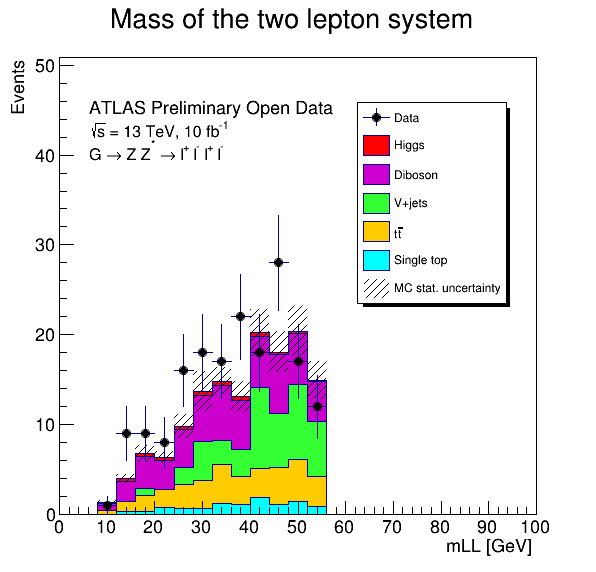

Info in <TCanvas::Print>: pdf file plots/HWW_Analysis_mLL.pdf has been created


In [20]:
plot_histogram_stacked("mLL");

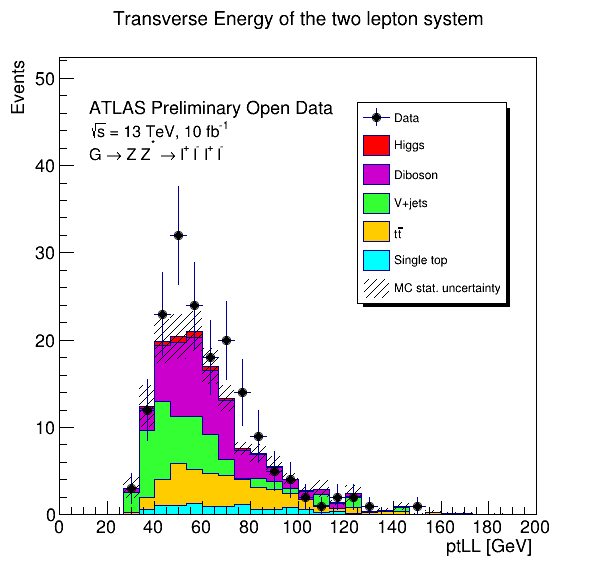

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can
Info in <TCanvas::Print>: pdf file plots/HWW_Analysis_ptLL.pdf has been created


In [21]:
plot_histogram_stacked("ptLL");

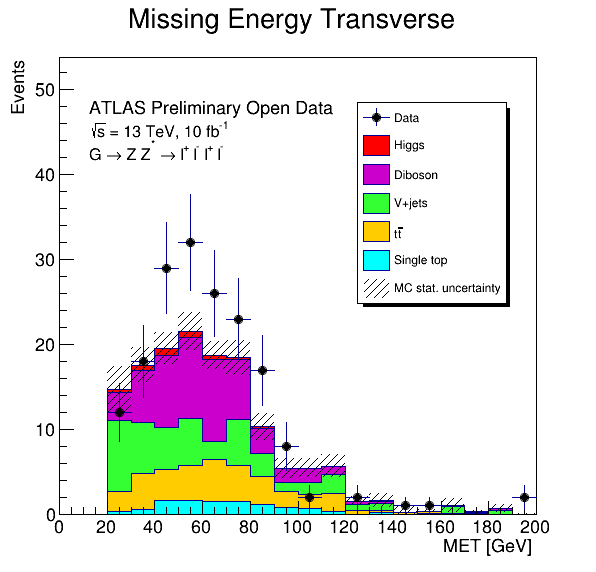

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can
Info in <TCanvas::Print>: pdf file plots/HWW_Analysis_etmiss.pdf has been created


In [22]:
plot_histogram_stacked("etmiss");

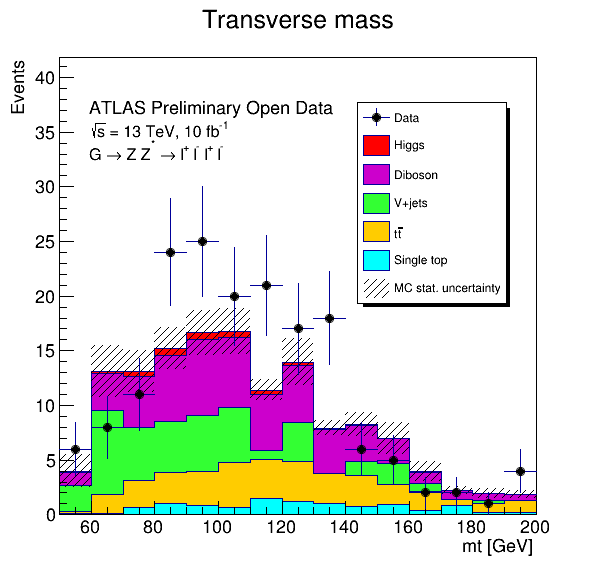

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can
Info in <TCanvas::Print>: pdf file plots/HWW_Analysis_mt.pdf has been created


In [23]:
plot_histogram_stacked("mt");